In [207]:
import pandas as pd
import numpy as np

import re

from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopandas as gpd
import folium

from shapely.geometry import polygon, multipolygon, Point

import mapclassify as mc
import libpysal as lp

from esda import moran # Morans
from splot.esda import plot_moran, moran_scatterplot

## Load District boundaries

In [30]:
districts_pop_gdf = gpd.read_file('data/Bangkok_districts_population.shp')

districts_pop_gdf.columns = ['district','population','area_sqkm','population_density','geometry']
districts_pop_gdf.head()

,district,population,area_sqkm,population_density,geometry
0,Ban Na,64323.0,2.951617e-08,2.179246e+12,"POLYGON ((101.06481 14.41179, 101.06536 14.410..."
1,Ban Pho,45252.0,1.733921e-08,2.609807e+12,"POLYGON ((100.96163 13.70401, 100.96242 13.703..."
2,Bang Bo,105742.0,1.827028e-08,5.787650e+12,"POLYGON ((100.93635 13.66819, 100.93792 13.667..."
3,Bang Bon,138698.0,3.017369e-09,4.596654e+13,"POLYGON ((100.43022 13.67181, 100.42820 13.669..."
4,Bang Bua Thong,256290.0,1.106805e-08,2.315584e+13,"POLYGON ((100.38375 13.98669, 100.38609 13.986..."


## Load Food Venues

In [9]:
venues_gdf = gpd.read_file('data/Bangkok_venues_likes.geojson',index_col=0)
venues_gdf

,city,id,name,category,likes,geometry
0,Bangkok,5d89ecb2ebc5f800083c9c72,วนิดาฟาร์ม ร้านอาหารทะเล ฟาร์มสเตย์ และบ่อตกปล...,Restaurant,0.0,POINT (100.08018 13.42733)
1,Bangkok,4f979611e4b0107577b7473d,น้ำดื่มไลออนคิงส์,Deli / Bodega,0.0,POINT (100.07984 13.42660)
2,Bangkok,4f019036c5126f14b907d325,ครัวแสงดาว,Seafood Restaurant,0.0,POINT (100.09205 13.43016)
3,Bangkok,4f2a1166e4b0d4e47d2b0990,อังเคิ้ลอาหารตามสั่ง ในปั้มน้ำมันบางจาก,Restaurant,0.0,POINT (100.07888 13.44924)
4,Bangkok,4ee0b7b80e01452f928d12ee,ลาบยโส ด่านช่างพระราม2 บางโทรัด สมุทรสาคร,Thai Restaurant,0.0,POINT (100.07936 13.44986)
...,...,...,...,...,...,...
56378,Bangkok,4e5a1b4c52b1b78b81a5ab1d,เรือนรับรองโรงเรียนเตรียม,Thai Restaurant,2.0,POINT (101.12332 14.30844)
56379,Bangkok,4feab941e4b07f87a595eb68,ร้านกาแฟพี่กุ้ง,Coffee Shop,0.0,POINT (101.11967 14.30635)
56380,Bangkok,4fbdc0d8e4b06a0de5ba961b,ก๋วยเตี๋ยวห้อยขา @ รร.เตรียมทหาร,Noodle House,0.0,POINT (101.12011 14.30625)
56381,Bangkok,5683b4e2498e95633f18c3bf,Wine I Love You Sweet Cafe,Donut Shop,0.0,POINT (101.11607 14.30994)


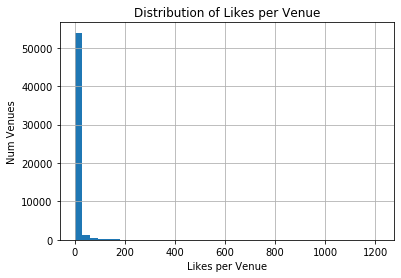

In [12]:
venues_gdf.likes.hist(bins=40)
plt.title('Distribution of Likes per Venue')
plt.xlabel('Likes per Venue')
plt.ylabel('Num Venues')
plt.show()

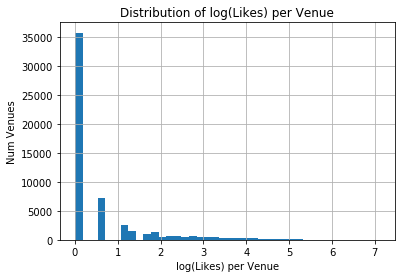

In [13]:
# Take log of 'likes' since its distribution is 0-skewed
venues_gdf['log_likes']=np.log(venues_gdf.likes+1) # correct for many zeros
venues_gdf.log_likes.hist(bins=40)
plt.title('Distribution of log(Likes) per Venue')
plt.xlabel('log(Likes) per Venue')
plt.ylabel('Num Venues')
plt.show()

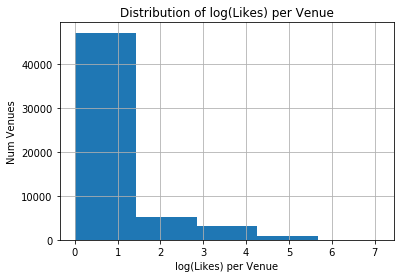

In [15]:
# Even binning log(Likes) produces very skewed value set
venues_gdf.log_likes.hist(bins=5)
plt.title('Distribution of log(Likes) per Venue')
plt.xlabel('log(Likes) per Venue')
plt.ylabel('Num Venues')
plt.show()

In [16]:
# venues_gdf['']
bc = boxcox(venues_gdf.likes+1)

print('boxcox lambda:', bc[1])
venues_gdf['boxcox_likes'] = bc[0]

boxcox lambda: -1.1225846908253287


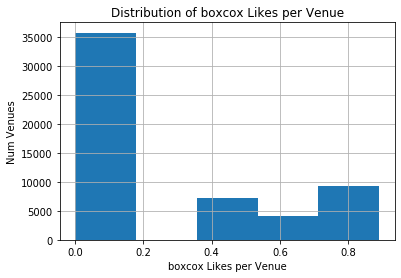

In [17]:
venues_gdf.boxcox_likes.hist(bins=5)
plt.title('Distribution of boxcox Likes per Venue')
plt.xlabel('boxcox Likes per Venue')
plt.ylabel('Num Venues')
plt.show()

In [18]:
# Since it is unlikely that greater than half of food venues provide zero value,
# convert boxcox_likes to ordinal values
venue_values=["zero","low","medium","high","highest"]
venues_gdf['venue_value'] = pd.cut(venues_gdf.boxcox_likes, 5, labels=venue_values)

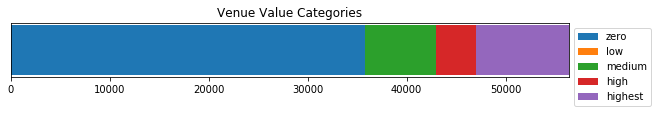

In [19]:
N = len(venues_gdf)
height = 0.02
counts = venues_gdf.venue_value.value_counts()

zero_count = counts[venue_values[0]]
low_count = counts[venue_values[1]]
med_count = counts[venue_values[2]]
high_count = counts[venue_values[3]]
highest_count = counts[venue_values[4]]

fig = plt.figure(figsize=(10,1))
ax = plt.subplot(111)

bar_zero = ax.barh(0, zero_count, height)
bar_low = ax.barh(0, low_count, height, left=zero_count)
bar_med = ax.barh(0, med_count, height, left=low_count+zero_count)
bar_high = ax.barh(0, high_count, height, left=med_count+low_count+zero_count)
bar_highest = ax.barh(0, highest_count, height, left=high_count+med_count+low_count+zero_count)

ax.set_title('Venue Value Categories')
ax.set_xlim(0,N)
ax.set_yticks([])
ax.legend((bar_zero[0], bar_low[0], bar_med[0], bar_high[0], bar_highest[0]),\
           tuple(venue_values), loc="upper left", bbox_to_anchor=(1,1))
plt.show()

In [20]:
print("zero category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='zero'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='zero'].likes.max()))
print("low category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='low'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='low'].likes.max()))
print("medium category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='medium'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='medium'].likes.max()))
print("high category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='high'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='high'].likes.max()))
print("higheset category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='highest'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='highest'].likes.max()))

zero category range: 0.0 - 0.0
low category range: nan - nan
medium category range: 1.0 - 1.0
high category range: 2.0 - 3.0
higheset category range: 4.0 - 1216.0


In [22]:
# After log transform, secondary category drops out with no members
# This also helps us maintain interpretability

venue_value_weights = {
    'zero': 0.25,
    'low': 0, # we expect none
    'medium': 0.5,
    'high': 0.75,
    'highest': 1
}

venues_gdf['venue_value_weight'] = venues_gdf.venue_value.apply(lambda x: venue_value_weights[x])
venues_gdf.head()

,city,id,name,category,likes,geometry,log_likes,boxcox_likes,venue_value,venue_value_weight
0,Bangkok,5d89ecb2ebc5f800083c9c72,วนิดาฟาร์ม ร้านอาหารทะเล ฟาร์มสเตย์ และบ่อตกปล...,Restaurant,0.0,POINT (100.08018 13.42733),0.0,0.0,zero,0.25
1,Bangkok,4f979611e4b0107577b7473d,น้ำดื่มไลออนคิงส์,Deli / Bodega,0.0,POINT (100.07984 13.42660),0.0,0.0,zero,0.25
2,Bangkok,4f019036c5126f14b907d325,ครัวแสงดาว,Seafood Restaurant,0.0,POINT (100.09205 13.43016),0.0,0.0,zero,0.25
3,Bangkok,4f2a1166e4b0d4e47d2b0990,อังเคิ้ลอาหารตามสั่ง ในปั้มน้ำมันบางจาก,Restaurant,0.0,POINT (100.07888 13.44924),0.0,0.0,zero,0.25
4,Bangkok,4ee0b7b80e01452f928d12ee,ลาบยโส ด่านช่างพระราม2 บางโทรัด สมุทรสาคร,Thai Restaurant,0.0,POINT (100.07936 13.44986),0.0,0.0,zero,0.25


In [23]:
venues_gdf.venue_value_weight = venues_gdf.venue_value_weight.astype(float)
venues_gdf.venue_value_weight.dtype

dtype('float64')

In [235]:
venues_gdf_to_save = gpd.sjoin(venues_gdf,districts_pop_gdf[['population','geometry']],op='within')
venues_gdf_to_save.drop('index_right',axis=1,inplace=True)
venues_gdf_to_save['venue_value_norm'] = venues_gdf_to_save.venue_value_weight/venues_gdf_to_save.population
venues_gdf_to_save

,city,id,name,category,likes,geometry,log_likes,boxcox_likes,venue_value,venue_value_weight,population,venue_value_norm
0,Bangkok,5d89ecb2ebc5f800083c9c72,วนิดาฟาร์ม ร้านอาหารทะเล ฟาร์มสเตย์ และบ่อตกปล...,Restaurant,0.0,POINT (100.08018 13.42733),0.000000,0.000000,zero,0.25,536323.0,4.661370e-07
1,Bangkok,4f979611e4b0107577b7473d,น้ำดื่มไลออนคิงส์,Deli / Bodega,0.0,POINT (100.07984 13.42660),0.000000,0.000000,zero,0.25,536323.0,4.661370e-07
2,Bangkok,4f019036c5126f14b907d325,ครัวแสงดาว,Seafood Restaurant,0.0,POINT (100.09205 13.43016),0.000000,0.000000,zero,0.25,536323.0,4.661370e-07
3,Bangkok,4f2a1166e4b0d4e47d2b0990,อังเคิ้ลอาหารตามสั่ง ในปั้มน้ำมันบางจาก,Restaurant,0.0,POINT (100.07888 13.44924),0.000000,0.000000,zero,0.25,536323.0,4.661370e-07
4,Bangkok,4ee0b7b80e01452f928d12ee,ลาบยโส ด่านช่างพระราม2 บางโทรัด สมุทรสาคร,Thai Restaurant,0.0,POINT (100.07936 13.44986),0.000000,0.000000,zero,0.25,536323.0,4.661370e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
56377,Bangkok,50c19e81e4b0de95d2408cbc,โรงอาหาร เตรียมทหาร,Thai Restaurant,0.0,POINT (101.13180 14.30499),0.000000,0.000000,zero,0.25,64323.0,3.886635e-06
56378,Bangkok,4e5a1b4c52b1b78b81a5ab1d,เรือนรับรองโรงเรียนเตรียม,Thai Restaurant,2.0,POINT (101.12332 14.30844),1.098612,0.631281,high,0.75,64323.0,1.165990e-05
56379,Bangkok,4feab941e4b07f87a595eb68,ร้านกาแฟพี่กุ้ง,Coffee Shop,0.0,POINT (101.11967 14.30635),0.000000,0.000000,zero,0.25,64323.0,3.886635e-06
56380,Bangkok,4fbdc0d8e4b06a0de5ba961b,ก๋วยเตี๋ยวห้อยขา @ รร.เตรียมทหาร,Noodle House,0.0,POINT (101.12011 14.30625),0.000000,0.000000,zero,0.25,64323.0,3.886635e-06


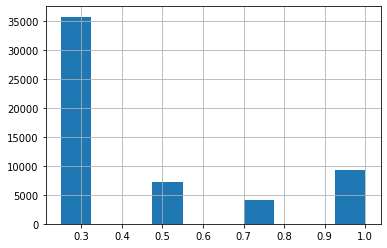

In [251]:
venues_gdf_to_save.venue_value_weight.hist()

In [241]:
venues_gdf_to_save.columns

Index(['city', 'id', 'name', 'category', 'likes', 'geometry', 'log_likes',
       'boxcox_likes', 'venue_value', 'venue_value_weight', 'population',
       'venue_value_norm'],
      dtype='object')

In [243]:
venues_gdf_to_save[['city', 'id', 'name', 'category', 'likes', 'geometry', 'log_likes',
       'boxcox_likes', 'venue_value_weight', 'population',
       'venue_value_norm']].to_file('data/Bangkok_venue_values_derived.geojson', driver='GeoJSON')

# venues_gdf[['id', 'category', 'geometry', 'likes', 'venue_value_weight']].to_file('data/Bangkok_venue_values.geojson', driver='GeoJSON')

In [176]:
venue_population_df =\
    gpd.sjoin(venues_gdf,districts_pop_gdf,how='right',op='within')\
        .groupby('district')\
        .agg({'geometry': 'first', 'population': 'first', 'venue_value_weight': 'sum', 'venue_value': 'count'})

venue_population_gdf =\
    gpd.GeoDataFrame(venue_population_df, crs={'init': 'epsg:4326'})

venue_population_gdf.reset_index(inplace=True)
venue_population_gdf.columns=['district','geometry','population','venue_value_sum','num_venues']
venue_population_gdf

,district,geometry,population,venue_value_sum,num_venues
0,Ban Na,"POLYGON ((101.06481 14.41179, 101.06536 14.410...",64323.0,108.50,299
1,Ban Pho,"POLYGON ((100.96163 13.70401, 100.96242 13.703...",45252.0,107.00,282
2,Bang Bo,"POLYGON ((100.93635 13.66819, 100.93792 13.667...",105742.0,116.50,307
3,Bang Bon,"POLYGON ((100.43022 13.67181, 100.42820 13.669...",138698.0,65.75,104
4,Bang Bua Thong,"POLYGON ((100.38375 13.98669, 100.38609 13.986...",256290.0,451.50,1094
...,...,...,...,...,...
80,Wang Noi,"POLYGON ((100.82285 14.32829, 100.82439 14.326...",86342.0,131.00,313
81,Wang Thonglang,"POLYGON ((100.58796 13.80530, 100.58826 13.805...",224013.0,269.25,604
82,Wattana,"POLYGON ((100.55692 13.75175, 100.55806 13.751...",171150.0,884.50,1704
83,Wihan Daeng,"POLYGON ((100.99131 14.42083, 100.99177 14.418...",48899.0,35.00,105


In [180]:
to_dissolve = venue_population_gdf[venue_population_gdf.num_venues < 30]
to_dissolve

,district,geometry,population,venue_value_sum,num_venues
23,Bangkok Yai,"POLYGON ((100.48710 13.74964, 100.48759 13.748...",89508.0,4.00,5
27,Din Dang,"POLYGON ((100.57342 13.80271, 100.57297 13.795...",158288.0,8.25,13
66,Ratchathewi,"POLYGON ((100.54492 13.76350, 100.54534 13.763...",108851.0,19.50,21
78,Thon Buri,"POLYGON ((100.49019 13.72648, 100.49074 13.725...",155583.0,14.25,18


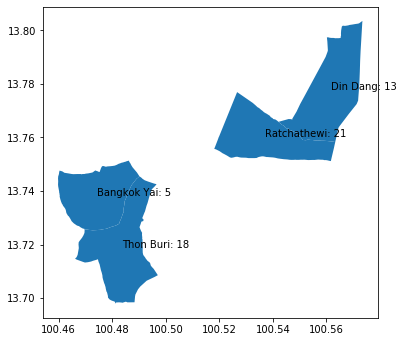

In [185]:
fig,ax=plt.subplots(figsize=(6,6))
to_dissolve.plot(ax=ax)
for i,v in to_dissolve.iterrows():
    ax.annotate("{}: {}".format(v.district,v.num_venues),v.geometry.centroid.coords[0])
plt.show()

In [186]:
venue_population_gdf['saturated_district'] = venue_population_gdf.district
venue_population_gdf.loc[23,'saturated_district'] = 'Bangkok Yai | Thon Buri'
venue_population_gdf.loc[78,'saturated_district'] = 'Bangkok Yai | Thon Buri' 
venue_population_gdf.loc[66,'saturated_district'] = 'Ratchathewi | Din Dang'
venue_population_gdf.loc[27,'saturated_district'] = 'Ratchathewi | Din Dang'

venue_population_gdf = venue_population_gdf.dissolve(by='saturated_district',aggfunc='sum',as_index=False)

In [187]:
venue_population_gdf['venues_per_capita'] =\
    venue_population_gdf['num_venues']/venue_population_gdf['population']
venue_population_gdf['venue_value_per_capita'] =\
    venue_population_gdf['venue_value_sum']/venue_population_gdf['population']

venue_population_gdf.head()

,saturated_district,geometry,population,venue_value_sum,num_venues,venues_per_capita,venue_value_per_capita
0,Ban Na,"POLYGON ((101.06481 14.41179, 101.06536 14.410...",64323.0,108.50,299,0.004648,0.001687
1,Ban Pho,"POLYGON ((100.96163 13.70401, 100.96242 13.703...",45252.0,107.00,282,0.006232,0.002365
2,Bang Bo,"POLYGON ((100.93635 13.66819, 100.93792 13.667...",105742.0,116.50,307,0.002903,0.001102
3,Bang Bon,"POLYGON ((100.43022 13.67181, 100.42820 13.669...",138698.0,65.75,104,0.000750,0.000474
4,Bang Bua Thong,"POLYGON ((100.38375 13.98669, 100.38609 13.986...",256290.0,451.50,1094,0.004269,0.001762


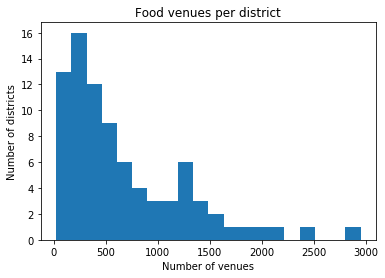

In [188]:
venue_population_gdf.num_venues.plot(kind='hist', bins=20)
plt.title('Food venues per district')
plt.xlabel('Number of venues')
plt.ylabel('Number of districts')
plt.show()

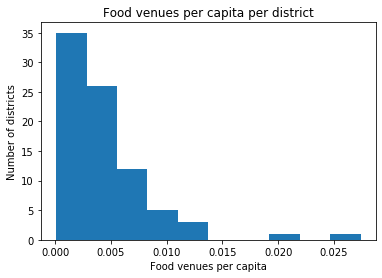

In [189]:
venue_population_gdf.venues_per_capita.plot(kind='hist')
plt.title('Food venues per capita per district')
plt.xlabel('Food venues per capita')
plt.ylabel('Number of districts')
plt.show()

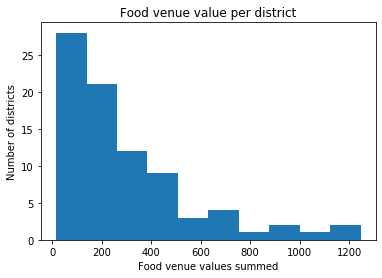

In [190]:
venue_population_gdf.venue_value_sum.plot(kind='hist')
plt.title('Food venue value per district')
plt.xlabel('Food venue values summed')
plt.ylabel('Number of districts')
plt.show()

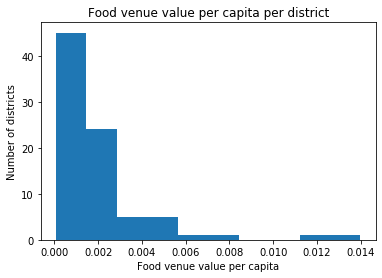

In [191]:
venue_population_gdf.venue_value_per_capita.plot(kind='hist')
plt.title('Food venue value per capita per district')
plt.xlabel('Food venue value per capita')
plt.ylabel('Number of districts')
plt.show()

In [192]:
len(venue_population_gdf[venue_population_gdf.num_venues > 30])

82

In [117]:
# After dissovling two borders, we still have one venue with fewer than 30 venues. 
# Due to its central location, it is better to include it than adhere strictly to rule-of-thumb guideline.

In [194]:
venue_population_gdf.columns = ['district', 'geometry', 'population', 'venue_value_sum',
       'num_venues', 'venues_per_capita', 'venue_value_per_capita']

In [249]:
venue_population_gdf[['district', 'geometry', 'population', 'venue_value_sum', 'num_venues',
       'venues_per_capita', 'venue_value_per_capita',
       'lag_venue_value_per_capita', 'p_value', 'z_score']].to_file('data/Bangkok-saturated-districts.shp')

In [195]:
loc = districts_pop_gdf.assign(city="Bangkok").dissolve(by='city').centroid

city_map = folium.Map(
    location=(loc.y,loc.x),
    zoom_start=10,
    tiles='cartodbpositron'
)

folium.Choropleth(
    geo_data=venue_population_gdf,
    name='choropleth',
    data=venue_population_gdf,
    columns=['district','venues_per_capita'],
    key_on='feature.properties.district',
    fill_color='Purples',
    bins=5,
    legend_name='Food Venues (per capita)'
).add_to(city_map)

city_map

In [196]:
city_map = folium.Map(
    location=(loc.y,loc.x),
    zoom_start=10,
    tiles='cartodbpositron'
)

folium.Choropleth(
    geo_data=venue_population_gdf,
    name='choropleth',
    data=venue_population_gdf,
    columns=['district','venue_value_per_capita'],
    key_on='feature.properties.district',
    fill_color='Purples',
    bins=5,
    legend_name='Food Venue Value (per capita)'
).add_to(city_map)

city_map

## Venue Value per Capita per District - Global Morans

In [197]:
# Global autocorrelation test - is the distribution of food venues random?

wq = lp.weights.Queen.from_dataframe(venue_population_gdf, idVariable='district')
wq.transform = 'r'

In [198]:
# Compute spatial lag - the weighted average of food venue value per capita per district
# The spatial leg standardizes the rows and takes the average value of the price in each district.

y = venue_population_gdf['venue_value_per_capita']
ylag = lp.weights.lag_spatial(wq, y)
ylag[0:5]

array([0.00110392, 0.00196204, 0.00166857, 0.00067352, 0.00140358])

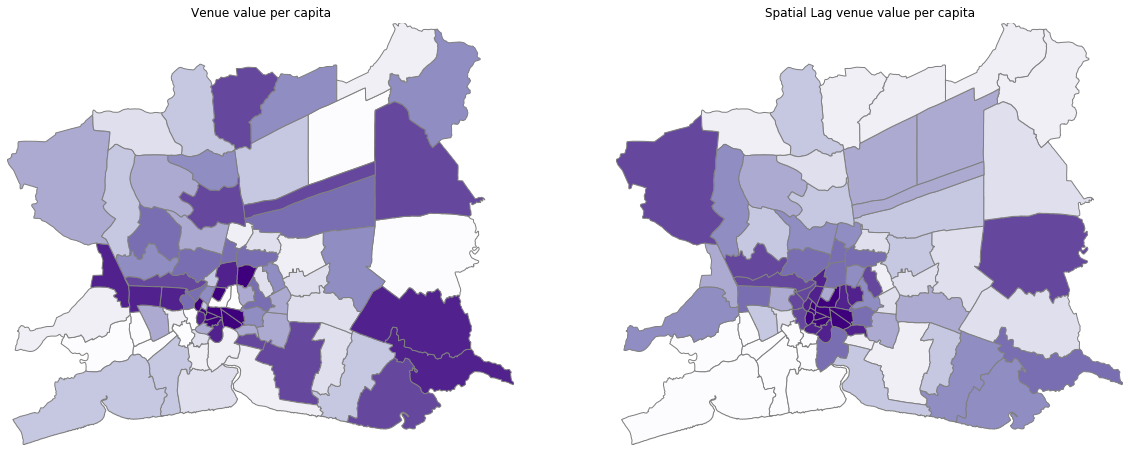

In [199]:
venue_population_gdf['lag_venue_value_per_capita'] = ylag #make this _gdf
f,ax = plt.subplots(1,2,figsize=(20,10))

venue_population_gdf.plot(column='venue_value_per_capita', ax=ax[0], edgecolor='grey',
        scheme="quantiles",  k=10, cmap='Purples')
ax[0].axis(venue_population_gdf.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Venue value per capita")

venue_population_gdf.plot(column='lag_venue_value_per_capita', ax=ax[1], edgecolor='grey',
        scheme='quantiles', cmap='Purples', k=10)
ax[1].axis(venue_population_gdf.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag venue value per capita")
ax[0].axis('off')
ax[1].axis('off')

plt.show()

Text(0.5, 0, "Moran's I")

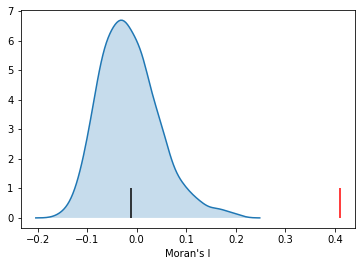

In [208]:
np.random.seed(123)
mi = moran.Moran(y, wq)

sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [209]:
# A p-value of 0.05 and less is significant
mi.p_sim

0.001

In [245]:
# Globally, distribution is statistically significant. 
# We reject our null hypothesis that venue distribution is random.

## Local Autocorrelation

In [217]:
li = moran.Moran_Local(y, wq)

# Determine number of statistically-significant hotspots/coldspots
print('Num clusters/outliers: ', (li.p_sim < 0.05).sum())

Num clusters/outliers:  17


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a32a16d10>)

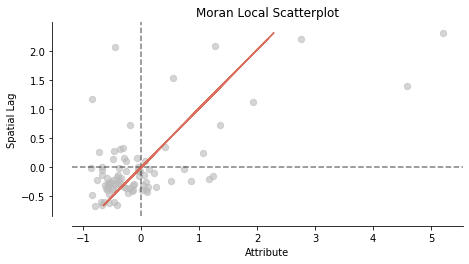

In [252]:
moran_scatterplot(li)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a3272a8d0>)

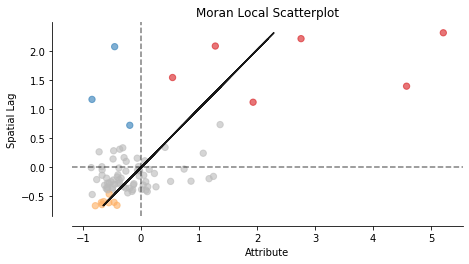

In [219]:
moran_scatterplot(li, p=0.05)

In [255]:
li?

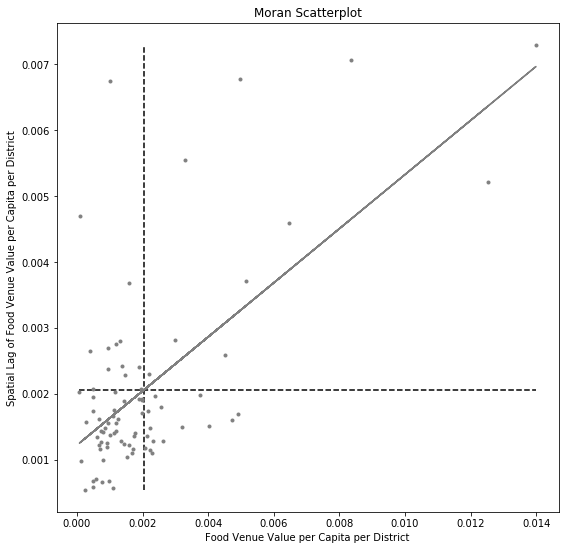

In [259]:
b, a = np.polyfit(y, ylag, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(y, ylag, '.', color='grey')

 # dashed vert at mean of the price
plt.vlines(y.mean(), ylag.min(), ylag.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(ylag.mean(), y.min(), y.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(y, a + b*y, 'grey')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Food Venue Value per Capita per District')
plt.xlabel('Food Venue Value per Capita per District')
plt.show()

In [220]:
sig = 1 * (li.p_sim < 0.05)

hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)

spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3,
       0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 2, 0, 0, 3, 2,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0])

In [221]:
spot_labels = ['0 not significant', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

In [222]:
venue_population_gdf.loc[:,'cluster_category'] = labels
venue_population_gdf.loc[:,'p_value'] = li.p_sim
venue_population_gdf.loc[:,'z_score'] = li.z_sim
venue_population_gdf.loc[:,'cluster_category'] = venue_population_gdf['cluster_category'].astype('category')
venue_population_gdf.head()

,district,geometry,population,venue_value_sum,num_venues,venues_per_capita,venue_value_per_capita,lag_venue_value_per_capita,cluster_category,p_value,z_score
0,Ban Na,"POLYGON ((101.06481 14.41179, 101.06536 14.410...",64323.0,108.50,299,0.004648,0.001687,0.001104,0 not significant,0.227,0.705342
1,Ban Pho,"POLYGON ((100.96163 13.70401, 100.96242 13.703...",45252.0,107.00,282,0.006232,0.002365,0.001962,0 not significant,0.342,0.008574
2,Bang Bo,"POLYGON ((100.93635 13.66819, 100.93792 13.667...",105742.0,116.50,307,0.002903,0.001102,0.001669,0 not significant,0.391,0.461579
3,Bang Bon,"POLYGON ((100.43022 13.67181, 100.42820 13.669...",138698.0,65.75,104,0.000750,0.000474,0.000674,3 cold spot,0.003,1.697114
4,Bang Bua Thong,"POLYGON ((100.38375 13.98669, 100.38609 13.986...",256290.0,451.50,1094,0.004269,0.001762,0.001404,0 not significant,0.280,0.667541


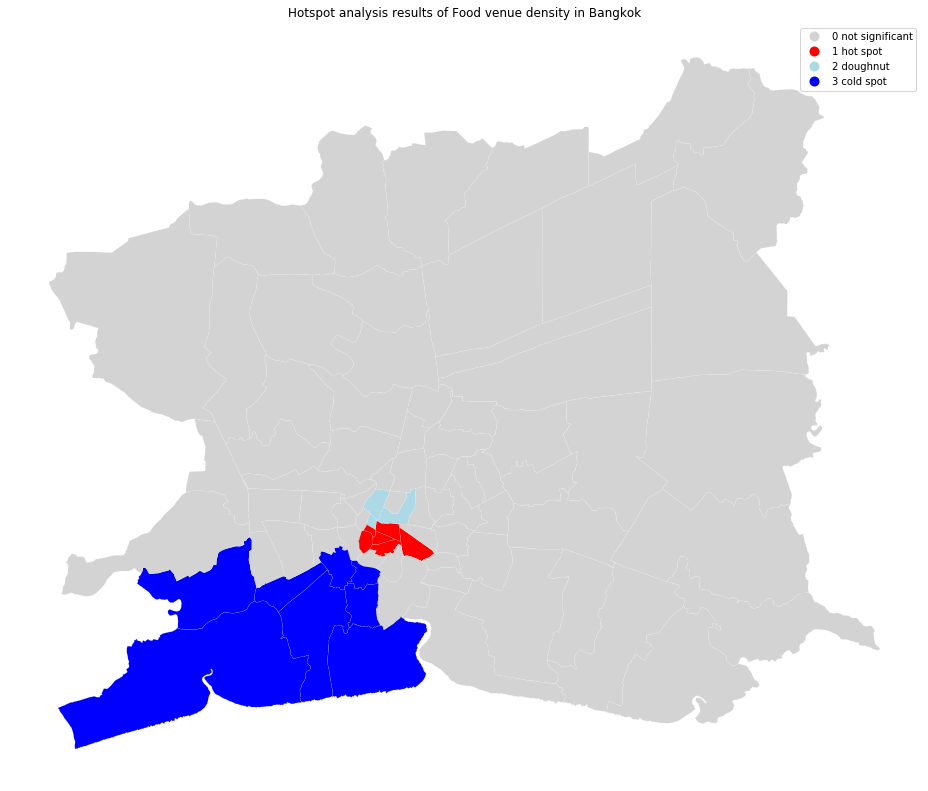

In [223]:
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue']) # 'pink' for diamonds excluded with zero data points
f, ax = plt.subplots(1, figsize=(20, 14))

venue_population_gdf.plot(column='cluster_category', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# venue_population_gdf.apply(lambda x:\
#                          ax.annotate(s=x.district, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

plt.title('Hotspot analysis results of Food venue density in Bangkok')
plt.show()

In [224]:
# Print Doughnut neighbourhoods in order of significance
venue_population_gdf[venue_population_gdf.cluster_category=='2 doughnut'][['district', 'p_value']]\
    .sort_values('p_value')

,district,p_value
61,Pom Pram Sattru,0.003
65,Ratchathewi | Din Dang,0.007
28,Dusit,0.048


In [ ]:
# Moran's I identifies 3 statistically-significant regions as opportunities for food delivery services.

In [225]:
# Print Hot Spot neighbourhoods in order of significance
venue_population_gdf[venue_population_gdf.cluster_category=='1 hot spot'][['district', 'p_value']]\
    .sort_values('p_value')

,district,p_value
17,Bang Rak,0.001
34,Khlong San,0.001
54,Pathum Wan,0.001
72,Sathorn,0.001
70,Samphantawong,0.002
35,Khlong Toey,0.009


In [226]:
# Print Cold Spot neighbourhoods in order of significance
venue_population_gdf[venue_population_gdf.cluster_category=='3 cold spot'][['district', 'p_value']]\
    .sort_values('p_value')

,district,p_value
26,Chom Thong,0.002
36,Krathum Baen,0.002
3,Bang Bon,0.003
21,Bangkhuntien,0.006
77,Thungkru,0.007
48,Muang Samut Sakhon,0.014
59,Phra Samut Jadee,0.015
64,Rat Burana,0.044


In [228]:
venue_population_gdf.reset_index()[['index','district', 'geometry', 'venue_value_per_capita',
       'lag_venue_value_per_capita', 'p_value',
       'z_score']].to_file('data/output-Bangkok.shp')

In [231]:
venue_population_gdf.reset_index()[['index','district', 'population','geometry', 'venue_value_sum', 'venue_value_per_capita',
       'lag_venue_value_per_capita', 'p_value',
       'z_score']].to_file('data/output-Bangkok.geojson',driver="GeoJSON")